### Dataset

In [1]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()
dataset = pd.DataFrame(
  iris['data'],
  columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
)
dataset['species'] = iris['target']
dataset = dataset.sample(frac=1)
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
148,6.2,3.4,5.4,2.3,2
21,5.1,3.7,1.5,0.4,0
97,6.2,2.9,4.3,1.3,1
130,7.4,2.8,6.1,1.9,2
40,5.0,3.5,1.3,0.3,0


In [2]:
import matplotlib.pyplot as plt

df = dataset[(dataset['species'] == 0) | (dataset['species'] == 1)]
x_df = df[['sepal_length', 'sepal_width']]
y_df = df['species']
c = ['blue' if s==0 else 'red' for s in y_df]

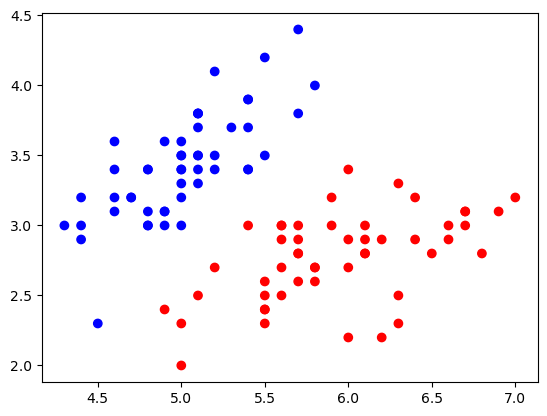

In [3]:
plt.scatter(x_df['sepal_length'], x_df['sepal_width'], c=c)
plt.show()

### Model

In [4]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, features=2):
        super().__init__()
        self.w = nn.Parameter(torch.randn(size=(features,), device=device))
        self.b = nn.Parameter(torch.randn(size=(), device=device))
        self.activation = nn.Sigmoid()
    def forward(self, x):
        return self.activation(x @ self.w + self.b)

model = LogisticRegression()

x = torch.tensor(x_df.values, dtype=torch.float32, device=device)
y_true = torch.tensor(y_df.values, dtype=torch.float32, device=device)

In [6]:
from torch.nn.functional import binary_cross_entropy

with torch.no_grad():
    p = model(x)
    L = binary_cross_entropy(p, y_true, reduction='none')
    df = pd.DataFrame({
        'y_i': y_true.cpu().numpy(),
        'p_i': p.cpu().numpy(),
        'l_i': L.cpu().numpy()
    })

df.head()

,y_i,p_i,l_i
0,0.0,0.977676,3.802105
1,1.0,0.907866,0.096658
2,0.0,0.969899,3.503189
3,0.0,0.968854,3.469058
4,0.0,0.967220,3.417933


### Training

In [7]:
model = LogisticRegression()
loss = binary_cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
epochs = 10000

In [8]:
for e in range(epochs):
    optimizer.zero_grad()
    p = model(x)
    l = binary_cross_entropy(p, y_true)
    l.backward()
    optimizer.step()
    if e % 1000 == 0:
        print(f"error = {l.item()}")

error = 11.05789566040039
error = 0.05506723374128342
error = 0.04687982052564621
error = 0.042528919875621796
error = 0.03930886089801788
error = 0.036627527326345444
error = 0.034285448491573334
error = 0.03219680115580559
error = 0.030316894873976707
error = 0.028617531061172485


In [9]:
model.w, model.b

(Parameter containing:
 tensor([  8.3290, -11.0312], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(-10.9784, device='cuda:0', requires_grad=True))

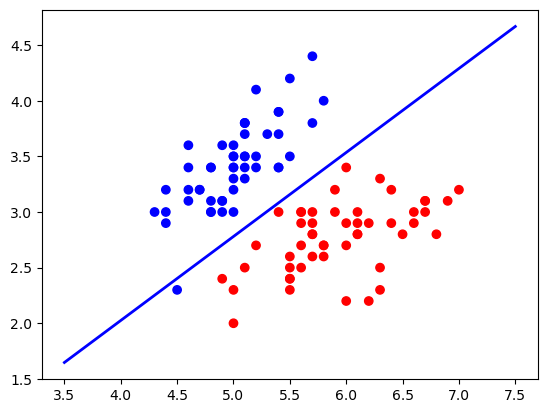

In [10]:
import numpy as np

def f(x):
    return -(model.w[0].item()/model.w[1].item())*x - (model.b.item()/model.w[1].item())
x_p = np.linspace(3.5, 7.5, 100)


plt.scatter(x_df['sepal_length'], x_df['sepal_width'], c=c)
plt.plot(x_p, f(x_p), 'b-', linewidth=2)
plt.show()

In [11]:
sample = dataset[dataset.species == 1].iloc[:20]
sample

,sepal_length,sepal_width,petal_length,petal_width,species
97,6.2,2.9,4.3,1.3,1
80,5.5,2.4,3.8,1.1,1
58,6.6,2.9,4.6,1.3,1
85,6.0,3.4,4.5,1.6,1
98,5.1,2.5,3.0,1.1,1
75,6.6,3.0,4.4,1.4,1
50,7.0,3.2,4.7,1.4,1
95,5.7,3.0,4.2,1.2,1
90,5.5,2.6,4.4,1.2,1
89,5.5,2.5,4.0,1.3,1


In [12]:
sample_x = torch.tensor(sample.loc[:,['sepal_length', 'sepal_width']].to_numpy(), dtype=torch.float32, device=device)
print(f"predicted species = {model(sample_x)}")

predicted species = tensor([0.9998, 0.9998, 1.0000, 0.8160, 0.9806, 1.0000, 1.0000, 0.9678, 0.9979,
        0.9993, 0.9995, 0.9996, 0.9963, 0.9460, 0.9891, 1.0000, 0.9991, 1.0000,
        0.9998, 0.9752], device='cuda:0', grad_fn=<SigmoidBackward0>)


### Generalizing to Multiple Classes

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2,3)
    def forward(self, x):
        return nn.functional.softmax(self.linear(x), dim=-1)

In [15]:
x_input = torch.tensor(
    dataset[['sepal_length', 'sepal_width']].values,
    dtype=torch.float32,
    device=device)

y_true = torch.tensor(dataset['species'].values,
                      dtype=torch.float32,
                      device=device)

model = Classifier().to(device=device)
p_pred = model(x_input)
p_pred[:5]

tensor([[0.7362, 0.0195, 0.2442],
        [0.4672, 0.0246, 0.5082],
        [0.8220, 0.0207, 0.1573],
        [0.9263, 0.0113, 0.0623],
        [0.5005, 0.0274, 0.4722]], device='cuda:0', grad_fn=<SliceBackward0>)

In [16]:
y_true[:5]

tensor([2., 0., 1., 2., 0.], device='cuda:0')

In [17]:
one_hots = nn.functional.one_hot(
    y_true.to(torch.int64),
    3
)
one_hots[:5]

tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]], device='cuda:0')

In [18]:
crossentropies = -torch.sum(one_hots * torch.log(p_pred), axis=-1)

In [20]:
df = pd.DataFrame(p_pred.detach().cpu())
df['y_true'] = y_true.int().cpu()
df['crossEntropy'] = crossentropies.detach().cpu()
df.head()

,0,1,2,y_true,crossEntropy
0,0.736225,0.019546,0.244229,2,1.409650
1,0.467240,0.024574,0.508185,0,0.760911
2,0.822013,0.020715,0.157272,1,3.876881
3,0.926343,0.011340,0.062317,2,2.775513
4,0.500473,0.027354,0.472173,0,0.692202


In [31]:
model = nn.Linear(2,3).to(device=device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 100000

for e in range(epochs):
    optimizer.zero_grad()
    logits = model(x_input)
    l = loss(logits, y_true.to(torch.int64))
    l.backward()
    optimizer.step()
    if e%10000 == 0:
        print(f"epoch = {e}, loss = {l.item()}")

epoch = 0, loss = 4.489696502685547
epoch = 10000, loss = 0.40840280055999756
epoch = 20000, loss = 0.4004611074924469
epoch = 30000, loss = 0.39605915546417236
epoch = 40000, loss = 0.3926476240158081
epoch = 50000, loss = 0.3898777961730957
epoch = 60000, loss = 0.3876136839389801
epoch = 70000, loss = 0.3857569694519043
epoch = 80000, loss = 0.38422438502311707
epoch = 90000, loss = 0.38294780254364014


In [32]:
model.eval()
y_pred = model(x_input).argmax(axis=1)
print(f"Predicted class = {y_pred[:5]}")
print(f'True labels = {y_true[:5]}')
print(f"accuracy = {torch.sum(y_pred == y_true)/y_true.shape[0]}")

Predicted class = tensor([2, 0, 1, 2, 0], device='cuda:0')
True labels = tensor([2., 0., 1., 2., 0.], device='cuda:0')
accuracy = 0.8266667127609253


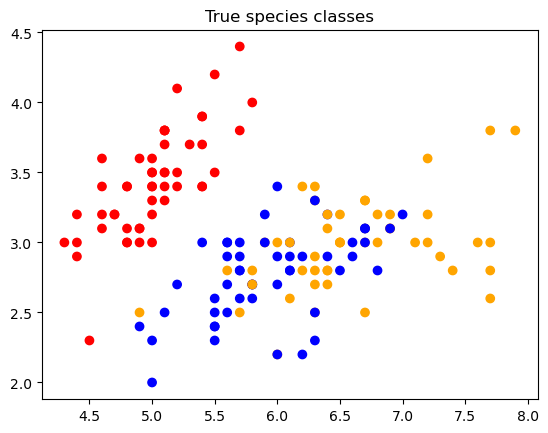

In [36]:
colormap = {
    0: 'red',
    1: 'blue',
    2: 'orange',
}
c = [colormap[y] for y in y_true.cpu().numpy()]
plt.scatter(x_input[:,0].cpu(), x_input[:, 1].cpu(), c=c)
plt.title('True species classes')
plt.show()